In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# <font color='red' >👍※</font>redwine 품질 등급 예측
```
1. 데이터셋 확보 & 전처리
    독립변수와 타겟변수 분리  -> 독립변수 스케일 조정(StandardScaler) - > 타겟변수원핫인코딩(get_dummies) - > 훈련셋과 테스트분리(train_test_split)
2. 모델 구성(입력11, 출력?)
3. 모델 학습과정 설정(다중분류로 설정)
4. 모델 학습(callbacks 이용)
5. 모델 평가 - 그래프, 평가(테스트셋), 교차표
6. 모델 저장 / 사용
```

In [2]:
import numpy as np
import pandas as pd # read_csv, get_dummies, crosstab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# 1.데이터셋 확보 & 전처리
- 독립변수와 타겟변수 분리  -> 독립변수 스케일 조정(StandardScaler) - > 타겟변수원핫인코딩(get_dummies) - > 훈련셋과 테스트분리(train_test_split)

In [3]:
# 데이터읽어오기
# np.loadtxt('data/winequality-red.csv',delimiter=';',skiprows=1)
# np.genfromtxt('data/winequality-red.csv',delimiter=';',skip_header=1)
redwine = pd.read_csv('./data/winequality-red.csv',sep=';')

# 고정 산도(fixed acidity)
# 휘발성 산도(volatile acidity)
# 구연산(citric acid)
# 잔여 당분(residual sugar)
# 염화물(chlorides)
# 유리 아황산염(free sulfur dioxide)
# 총 아황산염(total sulfur dioxide)
# 밀도(density)
# pH
# 황산염(sulphates)
# 알코올(alcohol)

redwine.head(),redwine.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


(   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.4              0.70         0.00             1.9      0.076   
 1            7.8              0.88         0.00             2.6      0.098   
 2            7.8              0.76         0.04             2.3      0.092   
 3           11.2              0.28         0.56             1.9      0.075   
 4            7.4              0.70         0.00             1.9      0.076   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 11.0                  34.0   0.9978  3.51       0.56   
 1                 25.0                  67.0   0.9968  3.20       0.68   
 2                 15.0                  54.0   0.9970  3.26       0.65   
 3                 17.0                  60.0   0.9980  3.16       0.58   
 4                 11.0                  34.0   0.9978  3.51       0.56   
 
    alcohol  quality  
 0      9.4        5  
 1      9.8        5  
 2 

In [9]:
# 타겟변수의 균형
redwine['quality'].value_counts()
# redwine['quality'].value_counts(normalize=True)

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [10]:
# 독립변수,타겟변수 분리
X_redwine = redwine.iloc[:,:-1].values  # to_numpy와 유서. numpy 배열로
y_redwine = redwine.iloc[:,-1]          #  3,4,5,6,7,8  
X_redwine.shape,y_redwine.shape

((1599, 11), (1599,))

In [24]:
# 독립변수 Xdml 스케일 조정
scaler = StandardScaler()
scaler.fit(X_redwine)
scaled_X_redwine = scaler.transform(X_redwine)

# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()
print('원데이터 ---> 원핫인코딩')
# 원핫인코딩한 0번째 인덱스가 3등급(get_dummies()사용해서)
np.column_stack([y_redwine[3:5],Y_redwine[3:5]])

원데이터 ---> 원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [14]:
# scaled_X_redwine[:1]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [12]:
# 독립변수: scaled_X_redwine & 타겟변수 : Y_redwine
scaled_X_redwine.shape,Y_redwine.shape

((1599, 11), (1599, 6))

In [26]:
# 훈련셋과  테스트셋 분리(층화추출)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine,
                                                   Y_redwine,
                                                   #test_size=0.3
                                                   train_size=0.7,
                                                   stratify=Y_redwine,  # 층화추출하기 위해
                                                    random_state=12)
X_train.shape, Y_train.shape,X_test.shape,Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [36]:
# 층화추출 확인 : 타겟변수의 균형
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

# 2.모델 구성(입력11, 출력6)

In [38]:
model = Sequential()
model.add(Input(11))
model.add(Dense(units=50,activation='relu'))
model.add(Dense(units=50,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30,'relu'))
model.add(Dense(units=6,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                600       
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 학습 과정 설정(다중분류에 맞는 설정)
# 4. 모델 학습(callbacks 이용)


In [42]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
class CustomHistory(Callback):    # on_epoch_end()함수가 epoch수행 후, 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self,batch,logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) |(self.epoch == 1):
            print('{}번째 loss : {:.4f}, acc : {:.4f}, val_loss : {:.4f}, val_acc : {:.4f}'\
                  .format(self.epoch,
                          logs.get('loss'),
                          logs.get('accuracy'),
                          logs.get('val_loss'),
                          logs.get('val_accuracy')
                         )
                 )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder):  # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
#콜백 객체
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
        filepath=file,
        monitor= 'val_accuracy', # 모니터링 지표 : loss,val_loss,accuracy
        save_best_only=True,     # 모니터 지표가 개선된 경우만 저장
        max = 'max',
        verbose=0)               # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss',patience=20)
# 학습
hist = model.fit(X_train,Y_train,epochs=200,batch_size=200,
                validation_split=0.2,    # 학습셋의 20%는 검증셋으로
                verbose=0,               # 로그출력 막음(콜백함수에서 출력)
                callbacks=[earlyStopping,
                          customHistory,
                          checkpoint])

1번째 loss : 1.7930, acc : 0.2279, val_loss : 1.7085, val_acc : 0.3705
5번째 loss : 1.3482, acc : 0.4894, val_loss : 1.3403, val_acc : 0.4732
10번째 loss : 1.0607, acc : 0.5687, val_loss : 1.1617, val_acc : 0.5268
15번째 loss : 0.9896, acc : 0.6078, val_loss : 1.1061, val_acc : 0.5446
20번째 loss : 0.9526, acc : 0.6134, val_loss : 1.0793, val_acc : 0.5536
25번째 loss : 0.9314, acc : 0.6190, val_loss : 1.0679, val_acc : 0.5491
30번째 loss : 0.9036, acc : 0.6279, val_loss : 1.0536, val_acc : 0.5670
35번째 loss : 0.8922, acc : 0.6201, val_loss : 1.0471, val_acc : 0.5580
40번째 loss : 0.8673, acc : 0.6346, val_loss : 1.0452, val_acc : 0.5580
45번째 loss : 0.8666, acc : 0.6402, val_loss : 1.0515, val_acc : 0.5491
50번째 loss : 0.8330, acc : 0.6570, val_loss : 1.0344, val_acc : 0.5446
55번째 loss : 0.8310, acc : 0.6503, val_loss : 1.0417, val_acc : 0.5402
60번째 loss : 0.8073, acc : 0.6570, val_loss : 1.0382, val_acc : 0.5491
65번째 loss : 0.7983, acc : 0.6626, val_loss : 1.0438, val_acc : 0.5357
70번째 loss : 0.7923, ac

# 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표
- 학습과정 시각화, 평가(테스트셋), 교차표(혼동행렬)


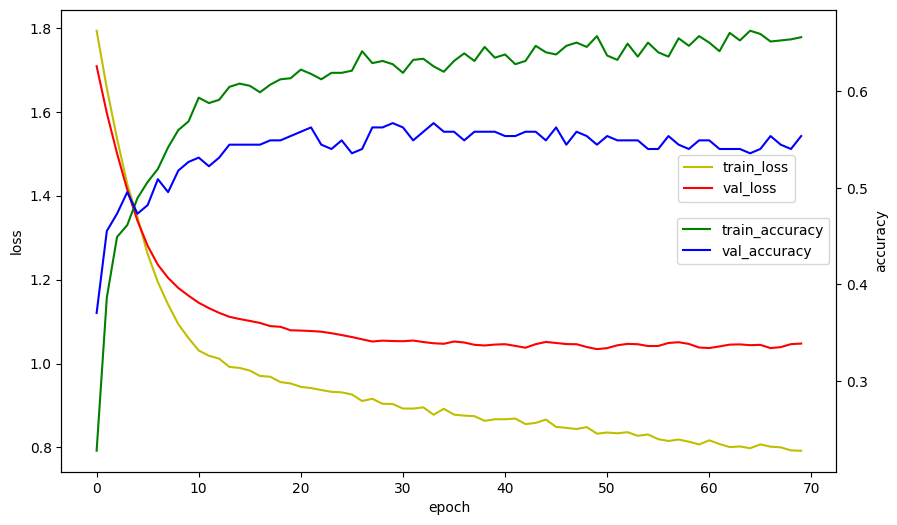

In [43]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [47]:
# 모델평가
loss_and_acc = model.evaluate(X_test,Y_test,batch_size=100,verbose=0)
print(f'loss:{loss_and_acc[0]:.4f},accuracy:{loss_and_acc[1]:.4f}')

loss:1.0092,accuracy:0.6125


In [54]:
model1 = load_model('model/wine-030-loss1.0536-acc0.5670.h5')
loss_and_acc1 = model1.evaluate(X_test,Y_test,verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f},accuracy:{loss_and_acc1[1]:.4f}')

loss:1.0280,accuracy:0.5813


In [68]:
# 모델 저장
model.save('model/wine.h5')

In [67]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = Y_test.argmax(axis=1) +3  # 실제값
# real = np.argmax(Y_test,axis=1)
pred = model.predict(X_test).argmax(axis=1) +3 # 예측값
#pred = np.argmax(model.predict(X_test),axis=1)

pd.crosstab(real,pred,rownames=['real'],colnames=['predict'])

15/15 [==============================] - 0s 1ms/step


predict,5,6,7
real,,,
3,3,0,0
4,9,6,1
5,146,54,4
6,59,123,10
7,4,31,25
8,0,4,1


# 6. 모델 사용

In [70]:
# redwine.loc[0:1]
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [75]:
input_data = [7.4,  0.7,  0.,  1.9,  0.076, 11., 34.0, 0.9978,  3.51,  0.56,  9.4]
scaled_data = scaler.transform([input_data]) # transform은 2차원 입력
model.predict(scaled_data).argmax(axis=1) + 3

1/1 [==============================] - 0s 15ms/step


array([5], dtype=int64)